In [1]:
# Author: Lee Yat Shun, Jasper
# Copyright (c) 2023 Lee Yat Shun, Jasper. All rights reserved.

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from caviar import CaviarModel
from backtesting import backtest
from var_tests import binomial_test, kupiec_pof_test, christoffersen_test, traffic_light_test

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = yf.download('SPY', start='2009-12-01')
df['Log Return'] = df['Close'].apply(lambda x: np.log(x)).diff()
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Log Return
Date,,,,,,,
2009-11-30,109.480003,110.199997,108.120003,109.940002,85.024315,160874800,NaN
2009-12-01,110.919998,111.660004,110.730003,111.300003,86.076096,159613700,0.012295
2009-12-02,111.279999,112.010002,110.919998,111.250000,86.037422,132315100,-0.000449
2009-12-03,111.550003,112.180000,110.290001,110.379997,85.364586,167324900,-0.007851
2009-12-04,111.839996,112.379997,110.040001,111.010002,85.851852,274907800,0.005691


In [5]:
returns = df['Log Return'].dropna()
low_open_log_difference = (df['Low'].apply(lambda x: np.log(x)) - df['Open'].apply(lambda x: np.log(x))).dropna()

In [6]:
in_samples = returns['2010':'2019'] * 100
out_of_samples = returns['2020':] * 100

In [7]:
# initiate parameter
quantile = 0.05 # 5% VAR

In [34]:
# instantiation
caviar_model = CaviarModel(quantile, model='symmetric', method='RQ')
caviar_model

CaviarModel(quantile=0.05, model=symmetric, method=RQ, G=10, tol=1e-10, LAGS=4)

In [35]:
caviar_model.fit(in_samples)

Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 0.8712414812512174
Update 1: 0.10671844268499518
Update 2: 0.10671844205883313
Update 3: 0.10671844204256986
Final loss: 0.10671844204256986
Time taken(s): 0.51


In [36]:
caviar_model.beta_summary()

,coefficient,S.E. of beta,pval of beta
beta1,-0.060809,0.057044,1.432140e-01
beta2,0.844893,0.058073,2.970481e-48
beta3,-0.260047,0.039679,2.805916e-11


### Backtesting on the out of samples

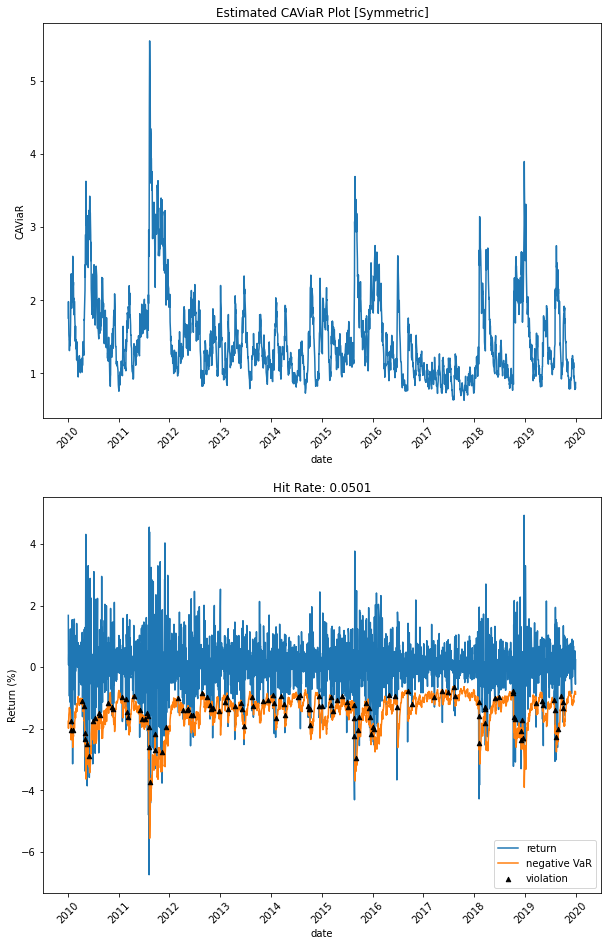

In [37]:
# in sample
caviar_model.plot_caviar(in_samples, 'in')

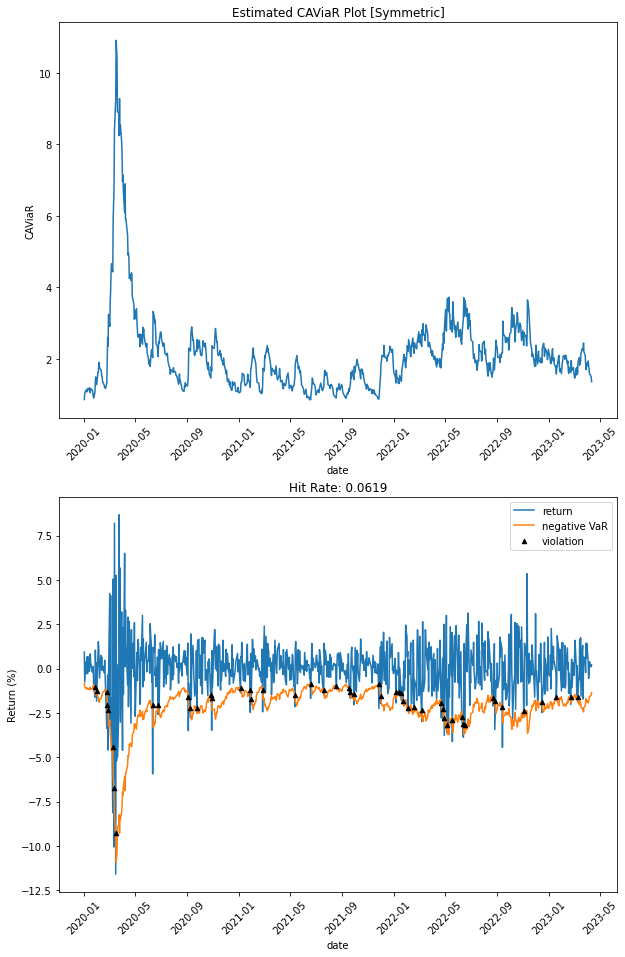

In [38]:
# out of sample
fig = caviar_model.plot_caviar(out_of_samples, 'out')

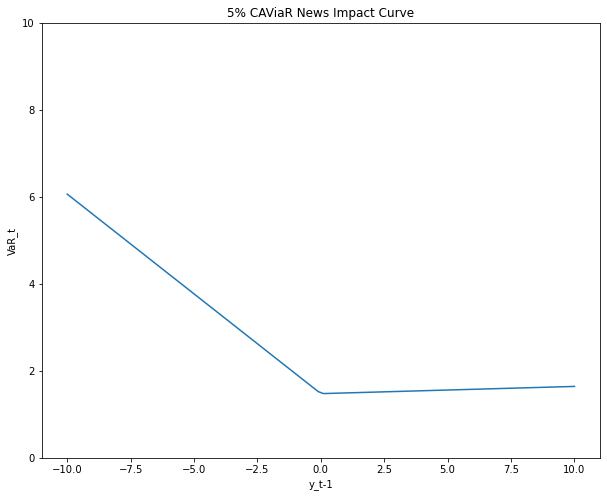

In [33]:
caviar_model.plot_news_impact_curve(VaR=-1.645)

### VaR Test

In [14]:
in_VaR = caviar_model.predict(in_samples, 'in')

In [15]:
out_VaR = caviar_model.predict(out_of_samples, 'out')

In [16]:
(out_of_samples < out_VaR[:-1]).value_counts(normalize=True)

False    0.930825
True     0.069175
Name: Log Return, dtype: float64

In [17]:
# The null hypothesis states that the current VaR violations are uncorrelated with past violations.

print(caviar_model.dq_test(in_samples, 'in'))
print(caviar_model.dq_test(out_of_samples, 'out'))

0.6444059789187606
0.0010640655527086038


In [18]:
# H0: the obs ~ binomial(p)

print(binomial_test(in_samples, in_VaR[:-1], caviar_model.quantile))
print(binomial_test(out_of_samples, out_VaR[:-1], caviar_model.quantile))

0.8908623978936323
0.01609963541286277


In [19]:
# H0: the observed failure rate is equal to the failure rate suggested by the confidence interval.

print(kupiec_pof_test(in_samples, in_VaR[:-1], caviar_model.quantile))
print(kupiec_pof_test(out_of_samples, out_VaR[:-1], caviar_model.quantile))

0.9127232902241807
0.01670640434268629


In [20]:
# null hypothesis: the observations are independent of each other

print(christoffersen_test(in_samples, in_VaR[:-1]))
print(christoffersen_test(out_of_samples, out_VaR[:-1]))

0.8096644094716235
0.5826363190639563


In [21]:
# Basel Committee (1996)

print(traffic_light_test(in_samples, in_VaR[:-1], caviar_model.quantile))
print(traffic_light_test(out_of_samples, out_VaR[:-1], caviar_model.quantile))

('green', 0.29092541456373194, 0)
('yellow', 0.9728546344729957, 0.4447130948622102)


### Forecast (totally unknown)

In [22]:
if len(out_VaR)-1 == len(out_of_samples):
    print('Day T+1 VaR forecast:', out_VaR[-1])

Day T+1 VaR forecast: -1.162336918354987


### Mean reversion property?

count    57.000000
mean      0.154065
std       1.854094
min      -3.870773
25%      -0.663416
50%      -0.094507
75%       0.740108
max       8.202809
Name: Log Return, dtype: float64
Date
2020-01-27    0.983841
2020-01-28    0.994097
2020-02-03    1.001454
2020-02-25    0.970639
2020-02-26    0.967062
2020-02-28    0.962990
2020-03-10    1.011574
2020-03-13    1.094551
2020-03-17    1.152108
2020-06-12    1.165823
2020-06-25    1.178255
2020-09-04    1.168596
2020-09-09    1.191447
2020-09-24    1.194619
2020-10-27    1.190493
2020-10-29    1.202532
2021-01-05    1.210786
2021-01-28    1.221154
2021-02-01    1.241314
2021-02-26    1.234901
2021-03-19    1.228576
2021-05-13    1.243246
2021-06-21    1.260918
2021-07-20    1.278860
2021-08-19    1.280838
2021-09-20    1.259301
2021-09-21    1.258111
2021-09-29    1.260227
2021-11-29    1.275592
2021-12-01    1.261344
2022-01-06    1.260159
2022-01-14    1.260674
2022-01-19    1.247515
2022-01-24    1.252802
2022-02-04    1.258679
2022-

<AxesSubplot:ylabel='Frequency'>

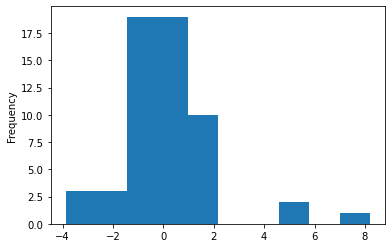

In [23]:
the_following_day = np.array(range(len(out_of_samples)))[out_of_samples < out_VaR[:-1]] + 1

print(out_of_samples.iloc[the_following_day].describe())
print((out_of_samples.iloc[the_following_day]/100 + 1).cumprod())

out_of_samples.iloc[the_following_day].plot.hist()

### Trading Strategy (Stop Loss)

In [24]:
out_low_open_log_difference = low_open_log_difference.loc[out_of_samples.index]
(out_low_open_log_difference * 100 < out_VaR[:-1]).value_counts(normalize=True)

False    0.918689
True     0.081311
dtype: float64

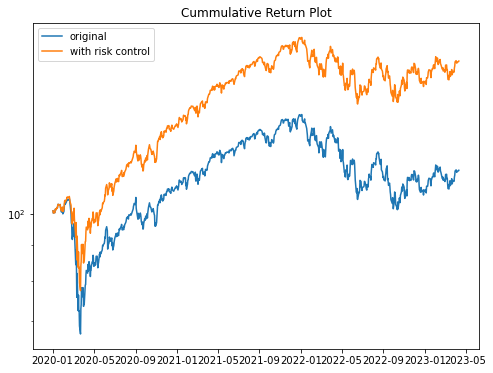

,annualized return (with CAViaR),cummulative return (with CAViaR),max. drawdown (with CAViaR),annualized return (original),cummulative return (original),max. drawdown (original)
0,0.167305,0.658373,-0.268354,0.044918,0.154504,-0.3614


In [27]:
# with 0.2% transaction cost
stat = backtest(out_of_samples, out_low_open_log_difference, out_VaR[:-1], ntl=100, penalty=0.002)

pd.DataFrame([stat], columns=[
    'annualized return (with CAViaR)',
    'cummulative return (with CAViaR)',
    'max. drawdown (with CAViaR)',
    'annualized return (original)',
    'cummulative return (original)',
    'max. drawdown (original)',
])